In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [3]:
# Function to merge datasets

def merge_datasets(d1, d2):

    return TensorDataset(d1[:][0],d2[:])

In [4]:
# Load datasets

y_true_train = torch.load('list_y_true_train.pt')
y_true_val = torch.load('list_y_true_val.pt')
y_true_test = torch.load('list_y_true_test.pt')

train_img = torch.load('detection_train.pt')
val_img = torch.load('detection_val.pt')
test_img = torch.load('detection_test.pt')

In [16]:
# Explore datasets
print(f"Total training elements: {len(y_true_train)}")
print(f"train_img dimensions: {train_img[0][0].shape}")

Total training elements: 26874
train_img dimensions: torch.Size([1, 48, 60])


In [17]:
# Function to convert coordinates to local coordinates

def convert_coordinates_to_local(x, y, w, h, H_out, W_out):
    cell_x = int(x * W_out)
    cell_y = int(y * H_out)
    
    local_x = (x * W_out) - cell_x
    local_y = (y * H_out) - cell_y
    
    return cell_x, cell_y, local_x, local_y, w, h


In [18]:
N_tot = len(y_true_train)
H_out = 2
W_out = 3

# Create tensors

y_train_tensor = torch.zeros((N_tot, H_out, W_out, 6))
print(f"Train tensor dimensions: {y_train_tensor.shape}")

N_val = len(y_true_val)
y_val_tensor = torch.zeros((N_val, H_out, W_out, 6))
print(f"Val tensor dimensions: {y_val_tensor.shape}")

N_test = len(y_true_test)
y_test_tensor = torch.zeros((N_test, H_out, W_out, 6))
print(f"Test tensor dimensions: {y_test_tensor.shape}")


Train tensor dimensions: torch.Size([26874, 2, 3, 6])
Val tensor dimensions: torch.Size([2967, 2, 3, 6])
Test tensor dimensions: torch.Size([4981, 2, 3, 6])


In [19]:
# Fill tensors

for img_idx, objects in enumerate(y_true_train):
    for obj in objects:
        pc, x, y, w, h, c = obj
        cell_x, cell_y, local_x, local_y, local_w, local_h = convert_coordinates_to_local(x, y, w, h, H_out, W_out)
        y_train_tensor[img_idx, cell_y, cell_x] = torch.tensor([pc, local_x, local_y, local_w, local_h, c])
    
for img_idx, objects in enumerate(y_true_val):
    for obj in objects:
        pc, x, y, w, h, c = obj
        cell_x, cell_y, local_x, local_y, local_w, local_h = convert_coordinates_to_local(x, y, w, h, H_out, W_out)
        y_val_tensor[img_idx, cell_y, cell_x] = torch.tensor([pc, local_x, local_y, local_w, local_h, c])

for img_idx, objects in enumerate(y_true_test):
    for obj in objects:
        pc, x, y, w, h, c = obj
        cell_x, cell_y, local_x, local_y, local_w, local_h = convert_coordinates_to_local(x, y, w, h, H_out, W_out)
        y_test_tensor[img_idx, cell_y, cell_x] = torch.tensor([pc, local_x, local_y, local_w, local_h, c])

import random

In [28]:
# Check random value

random_img_index = random.randint(0, N_tot - 1)
random_cell_y = random.randint(0, H_out - 1)
random_cell_x = random.randint(0, W_out - 1)

print(f"Data in image {random_img_index}, cell ({random_cell_y}, {random_cell_x}): {y_train_tensor[random_img_index, random_cell_y, random_cell_x]}")


Data in image 19755, cell (1, 1): tensor([1.0000, 0.8000, 0.1875, 0.1000, 0.3125, 1.0000])


In [29]:
# Merge the labels with the image data
train_data = merge_datasets(train_img, y_train_tensor)
val_data = merge_datasets(val_img, y_val_tensor)
test_data = merge_datasets(test_img, y_test_tensor)

# Create loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

# Check loader
for img, label in train_loader:
    print(f"Image dimensions: {img.shape}")
    print(f"Label dimensions: {label.shape}")
    break

Image dimensions: torch.Size([32, 1, 48, 60])
Label dimensions: torch.Size([32, 2, 3, 6])


In [30]:
# First model

class CustomObjectDetectionCNN(nn.Module):
    def __init__(self):
        super(CustomObjectDetectionCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=(3,2), stride=(3,3), padding=1)
        self.conv5 = nn.Conv2d(128, 7, kernel_size=1)

    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = self.conv5(x)  # Dont apply ReLU to the last layer to get negative values
        
        x_permuted = x.permute(0, 2, 3, 1)
        return x_permuted

In [105]:
# Second model

import torch.nn as nn
import torch.nn.functional as F

class CustomObjectDetectionCNN_V2(nn.Module):
    def __init__(self):
        super(CustomObjectDetectionCNN_V2, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=(4,3), stride=(3,3), padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 7, kernel_size=1)  # Output layer

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.conv5(x)  # No ReLU before final layer

        x_permuted = x.permute(0, 2, 3, 1)
        return x_permuted


In [79]:
# Third model

class CustomObjectDetectionCNN_V3(nn.Module):
    def __init__(self):
        super(CustomObjectDetectionCNN_V3, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=(2, 1), padding=1)
        self.conv6 = nn.Conv2d(512, 7, kernel_size=1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = self.conv6(x)  # No ReLU here, to allow for negative values in the output

        x_permuted = x.permute(0, 2, 3, 1)
        return x_permuted


In [31]:
# Loss function

def object_detection_loss(predictions, targets):
    loss_detection = nn.BCEWithLogitsLoss()
    loss_localization = nn.MSELoss()
    loss_classification = nn.BCEWithLogitsLoss()
    
    pred_detection = predictions[:, :, :, 0]  # p_c
    pred_localization = predictions[:, :, :, 1:5]  # [x, y, w, h]
    pred_classification_aux = predictions[:, :, :, 5:] # [c1, ..., cC]
    pred_classification = pred_classification_aux[:, :, :, 0].unsqueeze(-1)
    
    true_detection = targets[:, :, :, 0]
    true_localization = targets[:, :, :, 1:5]
    true_classification = targets[:, :, :, 5:]
    
    loss_A = loss_detection(pred_detection, true_detection)
    loss_B = loss_localization(pred_localization, true_localization)
    loss_C = loss_classification(pred_classification, true_classification)
    
    total_loss = loss_A + loss_B + loss_C
    
    return total_loss


In [58]:
# Train function

def train(model, train_loader, n_epochs, lr=0.001):

    optimizer = optim.Adam(model.parameters(), lr)
    criterion = object_detection_loss

    print('Starting training..')
    for epoch in range(n_epochs):
        model.train()
        
        for img, label in train_loader:
            optimizer.zero_grad()
            
            output = model(img)

            loss = criterion(output, label)

            loss.backward()

            optimizer.step()

        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}')

    print(f"Training of {model.__class__.__name__} completed.")


In [81]:
model = CustomObjectDetectionCNN()

train(model, train_loader, 100, 0.001)

Starting training..
Epoch 1/100, Loss: 0.4728
Epoch 2/100, Loss: 0.2635
Epoch 3/100, Loss: 0.2951
Epoch 4/100, Loss: 0.4063
Epoch 5/100, Loss: 0.1509
Epoch 6/100, Loss: 0.1531
Epoch 7/100, Loss: 0.1419
Epoch 8/100, Loss: 0.3361
Epoch 9/100, Loss: 0.1556
Epoch 10/100, Loss: 0.1970
Epoch 11/100, Loss: 0.1964
Epoch 12/100, Loss: 0.1920
Epoch 13/100, Loss: 0.2297
Epoch 14/100, Loss: 0.2597
Epoch 15/100, Loss: 0.0951
Epoch 16/100, Loss: 0.0912
Epoch 17/100, Loss: 0.2695
Epoch 18/100, Loss: 0.1402
Epoch 19/100, Loss: 0.1938
Epoch 20/100, Loss: 0.0961
Epoch 21/100, Loss: 0.1872
Epoch 22/100, Loss: 0.1521
Epoch 23/100, Loss: 0.2242
Epoch 24/100, Loss: 0.2026
Epoch 25/100, Loss: 0.1762
Epoch 26/100, Loss: 0.1636
Epoch 27/100, Loss: 0.1895
Epoch 28/100, Loss: 0.1106
Epoch 29/100, Loss: 0.1824
Epoch 30/100, Loss: 0.2033
Epoch 31/100, Loss: 0.1446
Epoch 32/100, Loss: 0.1485
Epoch 33/100, Loss: 0.1098
Epoch 34/100, Loss: 0.1760
Epoch 35/100, Loss: 0.1113
Epoch 36/100, Loss: 0.0427
Epoch 37/100, Los

In [106]:
model2 = CustomObjectDetectionCNN_V2()

train(model2, train_loader, 100, 0.001)

Starting training..
Epoch 1/100, Loss: 0.0851
Epoch 2/100, Loss: 0.0311
Epoch 3/100, Loss: 0.0261
Epoch 4/100, Loss: 0.0238
Epoch 5/100, Loss: 0.0149
Epoch 6/100, Loss: 0.0520
Epoch 7/100, Loss: 0.0271
Epoch 8/100, Loss: 0.1028
Epoch 9/100, Loss: 0.0177
Epoch 10/100, Loss: 0.0229
Epoch 11/100, Loss: 0.0301
Epoch 12/100, Loss: 0.0052
Epoch 13/100, Loss: 0.0779
Epoch 14/100, Loss: 0.0040
Epoch 15/100, Loss: 0.0072
Epoch 16/100, Loss: 0.0117
Epoch 17/100, Loss: 0.0037
Epoch 18/100, Loss: 0.0050
Epoch 19/100, Loss: 0.0057
Epoch 20/100, Loss: 0.0160
Epoch 21/100, Loss: 0.0046
Epoch 22/100, Loss: 0.0014
Epoch 23/100, Loss: 0.0029
Epoch 24/100, Loss: 0.0029
Epoch 25/100, Loss: 0.0037
Epoch 26/100, Loss: 0.0061
Epoch 27/100, Loss: 0.0013
Epoch 28/100, Loss: 0.0029
Epoch 29/100, Loss: 0.0843
Epoch 30/100, Loss: 0.0016
Epoch 31/100, Loss: 0.0035
Epoch 32/100, Loss: 0.0034
Epoch 33/100, Loss: 0.0809
Epoch 34/100, Loss: 0.0111
Epoch 35/100, Loss: 0.0017
Epoch 36/100, Loss: 0.0019
Epoch 37/100, Los

In [107]:
model3 = CustomObjectDetectionCNN_V3()

train(model3, train_loader, 100, 0.001)

Starting training..


In [37]:
# IoU function

def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    union_area = box1_area + box2_area - intersection_area
    
    iou = intersection_area / union_area
    return iou

# Evaluate function
def evaluate_model(model, val_loader):
    model.eval()
    total_iou = 0
    total_accuracy = 0
    n = 0

    for img, label in val_loader:
        output = model(img)
        
        for i in range(len(output)):
            for j in range(len(output[i])):
                for k in range(len(output[i][j])):
                    n += 1
                    pred = output[i][j][k]
                    true = label[i][j][k]
                    # Accuracy
                    if torch.sigmoid(pred[0]) >= 0.5 and true[0] == 1:
                            if pred[5] >= pred[6] and true[5] == 1:
                                total_accuracy += 1
                            elif pred[6] > pred[5] and true[5] == 0:
                                total_accuracy += 1
                    elif torch.sigmoid(pred[0]) < 0.5 and true[0] == 0:
                        total_accuracy += 1
                    
                    # IoU
                    pred_box = [pred[1], pred[2], pred[1] + pred[3], pred[2] + pred[4]]
                    true_box = [true[1], true[2], true[1] + true[3], true[2] + true[4]]
                    total_iou += calculate_iou(pred_box, true_box)
    
    avg_accuracy = total_accuracy / n
    avg_iou = total_iou / n
    
    return avg_accuracy, avg_iou



In [38]:
# Evaluate model
accuracy, iou = evaluate_model(model, val_loader)
print(f'Test accuracy: {accuracy:.4f}, Test IoU: {iou:.4f}')

Test accuracy: 0.9383, Test IoU: 0.7903


In [54]:
# Box drawing function

def draw_bounding_boxes_on_grid(image, true_grid_data, pred_grid_data, grid_size):

    H_out, W_out = grid_size
    fig, ax = plt.subplots()
    ax.imshow(image.permute(1, 2, 0))
    
    width, height = image.size(2), image.size(1)

    ancho_celda = width / W_out
    alto_celda = height / H_out


    for i in range(H_out):
        for j in range(W_out):
            p_c_true, x_true, y_true, w_true, h_true, c_true = true_grid_data[i, j]
            p_c_pred, x_pred, y_pred, w_pred, h_pred, c_pred1, c_pred2 = pred_grid_data[i, j]
            pred = "1" if c_pred1 > c_pred2 else "0"

            if p_c_true > 0.5: 
                x_abs_true = (j + x_true) * ancho_celda - (w_true * width) / 2
                y_abs_true = (i + y_true) * alto_celda - (h_true * height) / 2
                w_abs_true = w_true * width
                h_abs_true = h_true * height
                
                rect_true = patches.Rectangle((x_abs_true, y_abs_true), w_abs_true, h_abs_true, linewidth=2, edgecolor='g', facecolor='none', label='Verdadera')
                ax.add_patch(rect_true)

            if p_c_pred > 0.5:
                x_abs_pred = (j + x_pred) * ancho_celda - (w_pred * width) / 2
                y_abs_pred = (i + y_pred) * alto_celda - (h_pred * height) / 2
                w_abs_pred = w_pred * width
                h_abs_pred = h_pred * height
                
                rect_pred = patches.Rectangle((x_abs_pred, y_abs_pred), w_abs_pred, h_abs_pred, linewidth=2, edgecolor='r', facecolor='none', label='Predicha')
                ax.add_patch(rect_pred)
                plt.title(f'Prediction: {pred}, True: {c_true}')

    plt.axis('off')
    plt.show()


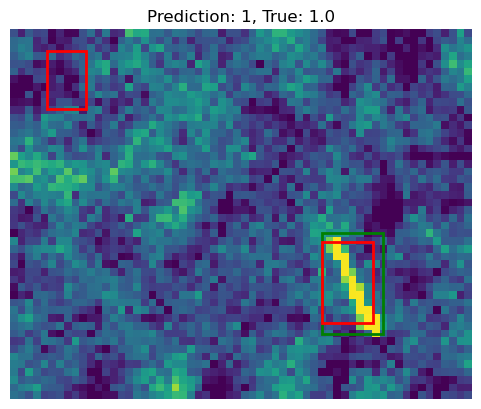

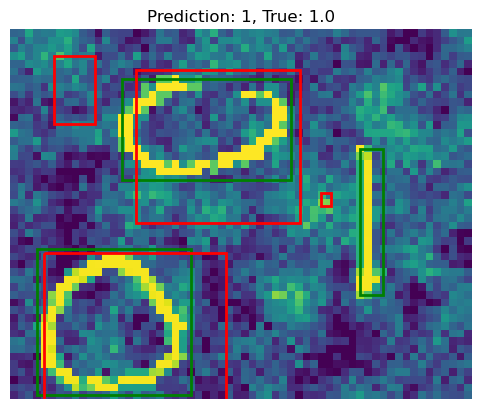

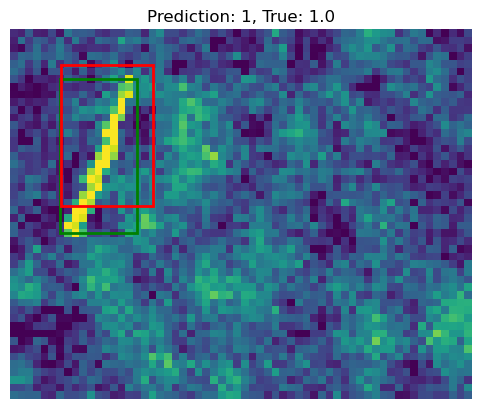

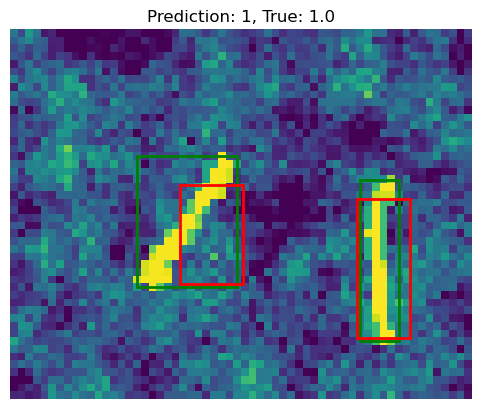

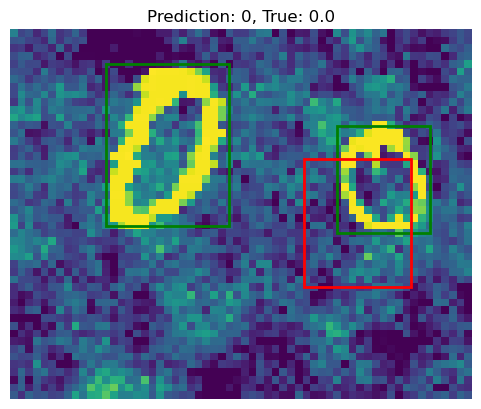

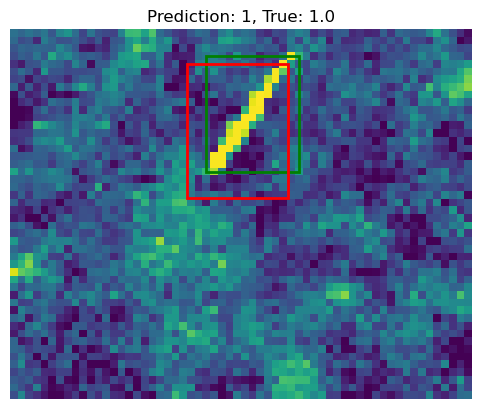

In [56]:
for img, label in val_loader:
    output = model(img)
    for i in range(6):
        draw_bounding_boxes_on_grid(img[i], label[i], output[i].detach(), (H_out, W_out))
    break